In [10]:
import numpy as np
from scipy.stats import laplace
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from Master_Functions import CondExtBivNegLogLik
from DeltaLaplaceFuncs import DeltaLaplace

In [8]:
# For module development
import geopy.distance
%load_ext autoreload
%autoreload 2

print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
numpy 1.19.5
geopy 2.1.0


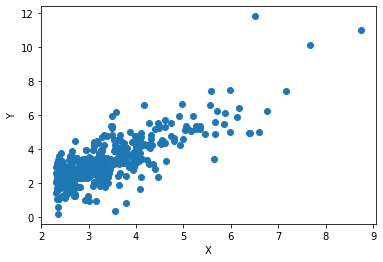

In [11]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(10000)

#We'll also let Z be Delta_Laplace noise

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X = X[X>u]
Z = DeltaLaplace(loc =0.1,scale = 0.3,shape = 1).rvs(size=len(X), random_state = 2)

Y = 0.9 * X + Z*(X**0.8)


fig=plt.figure()
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [12]:
## Fit distribution. We will use Delta-Laplace margins.If use_DL = False, uses Gaussian margins for residual.

init_par=[0.5,0.2,0.2,0.5,2]

X_data, Y_data = X,Y

use_DL = True

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data,use_DL),
               method="Nelder-Mead")

fit

 final_simplex: (array([[ 0.99420574,  0.99999979, -0.01435429,  0.22795461,  0.98155689],
       [ 0.99420298,  0.99999882, -0.01435189,  0.22795237,  0.98148161],
       [ 0.99420869,  0.99999761, -0.01435785,  0.22795906,  0.98163324],
       [ 0.99420783,  0.99999758, -0.01435713,  0.22794349,  0.98163641],
       [ 0.99420373,  0.99999807, -0.01435218,  0.22795259,  0.98150344],
       [ 0.99420731,  0.99999765, -0.01435574,  0.22794876,  0.98161394]]), array([1006.28086043, 1006.28086123, 1006.28086486, 1006.28086559,
       1006.280866  , 1006.28086659]))
           fun: 1006.2808604315655
       message: 'Optimization terminated successfully.'
          nfev: 687
           nit: 418
        status: 0
       success: True
             x: array([ 0.99420574,  0.99999979, -0.01435429,  0.22795461,  0.98155689])

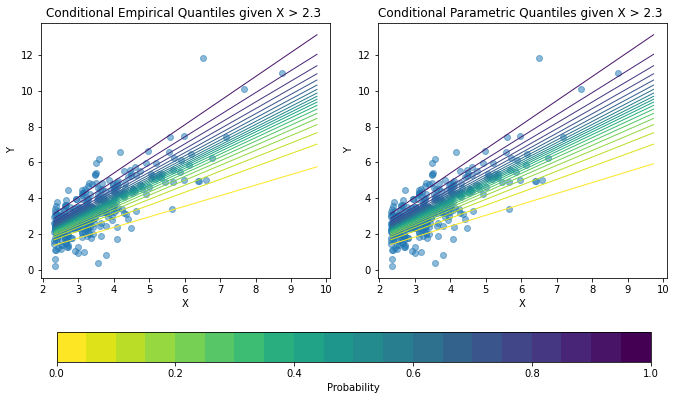

In [13]:
#Plot fit
from Master_Functions import plot_bivariate_condExt_fit

#This can be done using either the empirical residual quantiles or the parametric delta-Laplace quantiles. Choose between
#plot_type = ("Model","Empirical","Both")
#Other inputs:
#X,Y data for fitting - Can be unconditoned
#u - Threshold for conditional quantile Y| X > u. Should be greater than or equal to that used for fitting
#par_ests - parameter estimates. Only supports (alpha, beta, mu, sigma) or (alpha, beta, mu, sigma, delta)
#zoom - If True, plots only (X,Y)| X>u. Plots all data, otherwise.

u=min(X_data)
    
plot_bivariate_condExt_fit(X = X,Y = Y,u = u, par_ests = fit.x, probs = np.linspace(0.05,0.95,19), 
                           plot_type = "Both", zoom = True)



# Using real data - Australian summer heatwaves (Wadsworth and Tawn, 2019)


In [14]:
import pandas as pd

In [15]:
df=pd.read_csv("data/Aus_Temp_Values.csv", index_col=[0])
coords=pd.read_csv("data/Aus_Temp_Coordinates.csv", index_col=[0])


In [16]:
print(df.shape)
df.head()

##5324 observations, Summer only (DJF), 1957-2014
##There are 72 observation locations, (lat,lon) coordinates given in coords

(5234, 72)


,Location_Index.1,Location_Index.2,Location_Index.3,Location_Index.4,Location_Index.5,Location_Index.6,Location_Index.7,Location_Index.8,Location_Index.9,Location_Index.10,...,Location_Index.63,Location_Index.64,Location_Index.65,Location_Index.66,Location_Index.67,Location_Index.68,Location_Index.69,Location_Index.70,Location_Index.71,Location_Index.72
1,-1.429028,-2.278988,-1.623868,-0.584468,1.120629,-0.035781,-0.113780,-0.147076,0.172627,1.175413,...,3.120704,2.179615,0.554757,-0.549779,-0.593419,0.334144,2.813729,3.998774,1.905111,0.776986
2,-1.174794,-1.393772,-1.265354,-0.544497,0.513057,-0.480102,-0.471189,-0.433947,-0.075152,0.587901,...,3.579516,1.585841,0.188645,-0.549779,0.215532,0.951280,2.194935,1.040722,0.430709,0.125189
3,-0.549117,-0.702551,-0.394069,-0.014818,0.426604,-0.005363,0.070222,0.375267,0.449995,0.469660,...,2.544529,1.413991,0.089672,-0.882485,2.591860,2.100093,2.447230,1.546512,0.627535,0.178318
4,-0.035385,-0.099541,0.144866,0.559091,0.815525,0.439861,0.760504,1.399175,1.463920,0.699855,...,1.884780,0.991134,0.020066,-1.038561,0.970756,2.728311,1.791187,1.088917,0.857860,0.178318
5,-0.152179,-0.141339,-0.010755,-0.014818,-0.223382,0.258133,0.642676,0.960222,0.728334,0.149291,...,2.020650,1.033179,0.214584,-0.208213,-0.395770,0.178318,1.835690,1.620965,0.857860,0.327496


In [17]:
print(coords.shape)
coords.head()

n_locs = coords.shape[0]

(72, 2)


Data has already undergone site-wise marginal transformation to standard Laplace and so no pre-processing is required.

In [18]:
#For a single-pair of sites

Cond_site_ind = np.random.randint(0,n_locs - 1)
Dep_site_ind = np.random.choice(np.arange(0,n_locs - 1,1)[-(Cond_site_ind)],1)

Cond_site_ind, Dep_site_ind = 2,3

X = df.iloc[:,Cond_site_ind]
Y = df.iloc[:,Dep_site_ind]


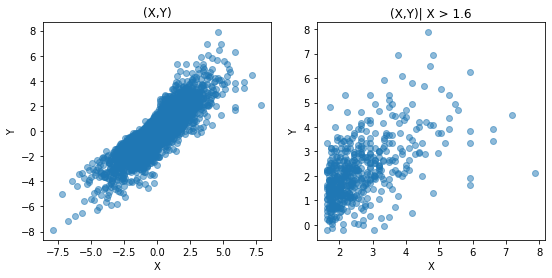

In [19]:
#Condition on X > u. We take u to be the 90% quantile.

u = np.quantile(X, 0.9)

X_data = X[X > u]
Y_data = Y[X > u]

fig , axs = plt.subplots(1,2, figsize=(9, 4))
axs[0].scatter(X,Y, alpha = 0.5)
axs[1].scatter(X_data,Y_data, alpha = 0.5)

axs[0].set(xlabel="X", ylabel="Y")
axs[1].set(xlabel="X", ylabel="Y")

axs[0].set_title("(X,Y)")
axs[1].set_title("(X,Y)| X > %.1f" %u)
plt.show()

In [20]:
## Fit bivariate Heff. and Tawn. Use Delta-Laplace margins.

init_par=[0.5,0.6,0.2,0.2,1]


use_DL = True

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data,use_DL),
               method="Nelder-Mead")

fit

 final_simplex: (array([[0.54520245, 0.64103334, 0.38476896, 0.59551754, 1.16373258],
       [0.54519154, 0.64109336, 0.38475624, 0.59547437, 1.16375045],
       [0.54522095, 0.64101636, 0.38474913, 0.59551411, 1.16376392],
       [0.54520245, 0.64103882, 0.3847672 , 0.59551088, 1.16375009],
       [0.5452207 , 0.64103233, 0.38474187, 0.59550832, 1.16375214],
       [0.54515765, 0.64110371, 0.38480678, 0.59547061, 1.16374309]]), array([1268.54347567, 1268.54347567, 1268.5434757 , 1268.54347578,
       1268.54347583, 1268.54347595]))
           fun: 1268.5434756719449
       message: 'Optimization terminated successfully.'
          nfev: 653
           nit: 400
        status: 0
       success: True
             x: array([0.54520245, 0.64103334, 0.38476896, 0.59551754, 1.16373258])

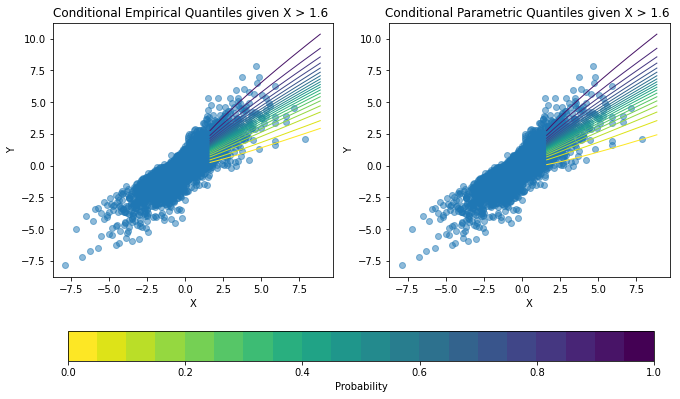

In [21]:
#Plot fit

u=min(X_data)
    
plot_bivariate_condExt_fit(X = X,Y = Y,u = u, par_ests = fit.x, probs = np.linspace(0.05,0.95,19), 
                           plot_type = "Both", zoom = False)


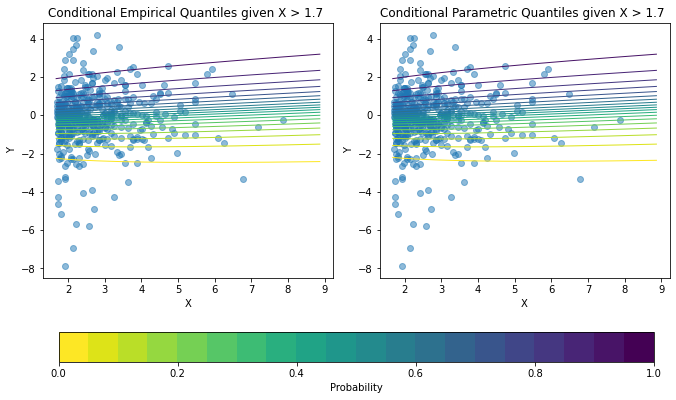

In [22]:
# Fit with less dependence

Cond_site_ind, Dep_site_ind = 0,71

X = df.iloc[:,Cond_site_ind]
Y = df.iloc[:,Dep_site_ind]

u = np.quantile(X, 0.9)

X_data = X[X > u]
Y_data = Y[X > u]

init_par=[0.5,0.6,0.2,0.2,1]


use_DL = True

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data,use_DL),
               method="Nelder-Mead")


u=min(X_data)
    
plot_bivariate_condExt_fit(X = X,Y = Y,u = u, par_ests = fit.x, probs = np.linspace(0.05,0.95,19),  plot_type = "Both", zoom = True)


In [23]:
fit.x
#Very small alpha and beta, so very low dependence. We would expect Y| X > u to be approximately standard Laplace.

array([ 0.09295242,  0.17804558, -0.27515342,  1.15720038,  0.96998164])

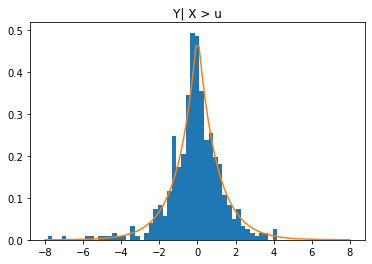

In [24]:
from scipy.stats import laplace

dist=laplace()
plt.hist(Y_data, 50, density = True)
plt.title('Y| X > u')

probs=dist.pdf(np.linspace(-8,8,100))
plt.plot(np.linspace(-8,8,100),probs)
plt.show()

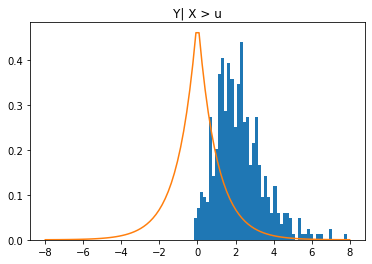

In [25]:
#And for the highly dependent pair?
Cond_site_ind, Dep_site_ind = 2,3

X = df.iloc[:,Cond_site_ind]
Y = df.iloc[:,Dep_site_ind]

u = np.quantile(X, 0.9)

X_data = X[X > u]
Y_data = Y[X > u]

plt.hist(Y_data, 50, density = True)
plt.title('Y| X > u')

probs=dist.pdf(np.linspace(-8,8,100))
plt.plot(np.linspace(-8,8,100),probs)
plt.show()
